# Torch.nn
torch.nn package中的内容是graph的basic building blocks。

### 1. preparing data

In [1]:
## download MNIST dataset

from pathlib import Path # python3 standary lib
import requests          # used to download dataset

DATA_PATH = Path("data")
PATH  = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [2]:
## extract data from original files

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). To plot one image, we need to reshape it to 2d first.

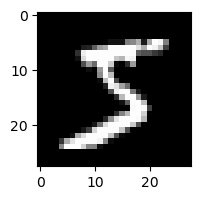

(50000, 784)


In [3]:
## plot a image

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(2, 2))
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
plt.show()
print(x_train.shape)

In [4]:
## convert the date from numpy arrays to tensors

import torch

x_train, y_train, x_val, y_val = map(torch.tensor, 
                                     (x_train, y_train, x_valid, y_valid))

N, C = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 2. construct a NN
### 2.1 只用最底层tensor operation
<font color=red>**· 完全手写函数**</font>

**step1: 初始化weights and bias**

In [5]:
import math

weights = torch.randn(784, 10)    # random init
weights /= math.sqrt(784)         # Xaiver init
weights.requires_grad_()          # init之后再set gradient，因为init不用求梯度
bias = torch.zeros(10, requires_grad=True)

**step2: 定义forward function, 用model打包**\
<font color=blue>· tensor调用的function都有对应的grad_fn，能自动构造graph，计算backward</font>

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # 'unsqueeze' is for broadcast   

def model(x_batch):
    return log_softmax(x_batch @ weights + bias)

**step3: 定义loss function**

In [7]:
def negative_log_likelyhood(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = negative_log_likelyhood

**step4: 定义accuracy function**

In [8]:
def accuracy(out, y_batch):
    preds = torch.argmax(out, dim=1)
    return (preds==y_batch).float().mean()

#### 一个完整的trainning loop
step1: mini-batch data\
step2: forward, make prediction\
step3: loss\
step4: backward\
step5: update

In [9]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
batch_size = 64

for epoch in range(epochs):
    for i in range((N - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i:end_i]
        y_batch = y_train[start_i:end_i]
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [10]:
print(loss_func(model(x_batch), y_batch), accuracy(model(x_batch), y_batch))

tensor(0.0837, grad_fn=<NegBackward0>) tensor(1.)


### 2.2 用相对底层的nn.functional
<font color=red>**· 只用很底层的function构件，只是不用手动实现act和loss func**</font>

In [11]:
import torch.nn.functional as F

loss_func = F.cross_entropy # loss function用nn.functional

def model(x_batch):
    return x_batch @ weights + bias

print(loss_func(model(x_batch), y_batch), accuracy(model(x_batch), y_batch))

tensor(0.0837, grad_fn=<NllLossBackward0>) tensor(1.)


### 2.3 用nn.Module, nn.Parameter
<font color=red>**· 自定义forward函数**</font>

In [12]:
from torch import nn
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, x_batch):
        return x_batch @ self.weights + self.bias

model = MnistLogistic()

print(loss_func(model(x_batch), y_batch))

tensor(2.4013, grad_fn=<NllLossBackward0>)


In [13]:
# run a training loop
lr = 0.5
epoch = 2

def fit(model, epoch, lr):
    for epoch in range(epochs):
        for i in range((N - 1) // batch_size + 1):
            start_i = i * batch_size
            end_i = start_i + batch_size
            x_batch = x_train[start_i: end_i]
            y_batch = y_train[start_i: end_i]
            pred = model(x_batch)
            loss = loss_func(pred, y_batch)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():  # nn.Module中的
                    p -= p.grad * lr
                model.zero_grad()
fit(model, epoch, lr)
print(loss_func(model(x_batch), y_batch))

tensor(0.0821, grad_fn=<NllLossBackward0>)


### 2.4 在nn.Module中用nn中的layers
<font color=red>**· forward直接调用nn自带的layer**</font>

In [14]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, x_batch):
        return self.lin(x_batch)

model = MnistLogistic()

# 一个batch
print(loss_func(model(x_batch), y_batch))

tensor(2.3593, grad_fn=<NllLossBackward0>)


In [15]:
# run a training loop
lr = 0.5
epoch = 2
fit(model, epoch, lr)
print(loss_func(model(x_batch), y_batch))

tensor(0.0829, grad_fn=<NllLossBackward0>)


### 2.5 用torch.optim
<font color=red>**· 自动完成gradient update**</font>

In [16]:
from torch import optim

lr = 0.5
epoch = 2

model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

# 一个batch
print(loss_func(model(x_batch), y_batch))

# run a trainning loop
for epoch in range(epochs):
    for i in range((N - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch = x_train[start_i: end_i]
        y_batch = y_train[start_i: end_i]
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)
            
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(x_batch), y_batch))

tensor(2.3589, grad_fn=<NllLossBackward0>)
tensor(0.0811, grad_fn=<NllLossBackward0>)


### 2.6 用Dataset
<font color=red>**· 用TensorDataset来wrapping dataset可以方便的iterate, index, slice a tensor along its first dimension**</font>

In [17]:
from torch.utils.data import TensorDataset

In [18]:
# 用TensorDataset来wrap dataset
train_ds = TensorDataset(x_train, y_train)

# 设置超参数
lr = 0.5
epoch = 2

# 设置模型
model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

# run a trainning loop
for epoch in range(epochs):
    for i in range((N - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        x_batch, y_batch = train_ds[start_i: end_i]
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)
            
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(x_batch), y_batch))

tensor(0.0802, grad_fn=<NllLossBackward0>)


### 2.7 用DataLoader
<font color=red>**· 自动获得batches，而不再用data[start_i: end_i]的方式手动提取数据**</font>

In [19]:
from torch.utils.data import DataLoader

In [20]:
# 准备数据
train_dset = TensorDataset(x_train, y_train)
train_dloader = DataLoader(train_dset, batch_size=batch_size)

# 设置超参数
lr = 0.5
epoch = 2

# 设置模型
model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

# run a trainning loop
for epoch in range(epochs):
    for x_batch, y_batch in train_dloader:
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)
            
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(x_batch), y_batch))

tensor(0.0832, grad_fn=<NllLossBackward0>)


### 2.8 增加validation
<font color=red>**· validation不做shuffle，batchsize可以跟training时不同**</font>

In [21]:
# 准备trainning和validation data
train_dset = TensorDataset(x_train, y_train)
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)

val_dset = TensorDataset(x_val, y_val)
val_dloader = DataLoader(val_dset, batch_size=batch_size*2)

# 设置超参数
lr = 0.5
epoch = 2

# 设置模型
model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

# run a trainning loop
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_dloader:
        pred = model(x_batch)
        loss = loss_func(pred, y_batch)
            
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(x_batch), y_batch) for x_batch, y_batch in val_dloader)

    print(valid_loss / len(val_dloader))

tensor(0.2966)
tensor(0.2931)


### 2.9 自定义简化流程的wrapper
<font color=red>**· 简化get_data和fit**</font>

In [22]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [23]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [24]:
def get_data(train_dset, val_dset, batch_size):
    return (
        DataLoader(train_dset, batch_size=batch_size, shuffle=True), 
        DataLoader(val_dset, batch_size=batch_size*2)
    )

In [25]:
train_dloader, val_dloader = get_data(train_dset, val_dset, batch_size)
model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)
fit(epochs, model, loss_func, opt, train_dloader, val_dloader)

0 0.34181232682466506
1 0.3006162665963173


### 2.10 用nn.sequential
<font color=red>**· X**</font> \
<font color=blue>**· 后面开始改用CNN模型**</font>: (cnn-relu) * 3 -> average_pooling

#### 没有用nn.sequential

In [26]:
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, x_batch):
        x_batch = x_batch.view(-1, 1, 28, 28)
        x_batch = F.relu(self.conv1(x_batch))
        x_batch = F.relu(self.conv2(x_batch))
        x_batch = F.relu(self.conv3(x_batch))
        x_batch = F.avg_pool2d(x_batch, 4)
        return x_batch.view(-1, x_batch.size(1))

lr = 0.1

model = MnistCNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dloader, val_dloader)

0 0.347343075799942
1 0.24481436341404914


#### 用nn.sequential

In [27]:
## 自定义layer要用nn.Module
#  自定义一个起数据预处理作用的view layer
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)
    
def preprocess_view(x):
    return x.view(-1, 1, 28, 28)

In [28]:
model = nn.Sequential(
    Lambda(preprocess_view), 
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(), 
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), 
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dloader, val_dloader)

0 0.3724334008693695
1 0.24540741817951203


### 2.11 wrapping DataLoader
<font color=red>**· 把数据预处理打包到自定义的DataLoader中，让model可以处理任意长宽的图片**</font>

In [29]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))

train_dloader, val_dloader = get_data(train_dset, val_dset, batch_size)
train_dloader = WrappedDataLoader(train_dloader, preprocess)
val_dloader = WrappedDataLoader(val_dloader, preprocess)

In [30]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dloader, val_dloader)

0 0.36414643461704255
1 0.2789471734046936


### 2.12 用GPU做运算

In [31]:
if torch.cuda.is_available():
    dev = torch.device("cuda") 
else:
    dev = torch.device("cpu")

# 数据预处理的时候将tensor移到gpu上
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dloader, val_dloader = get_data(train_dset, val_dset, batch_size)
train_dloader = WrappedDataLoader(train_dloader, preprocess)
val_dloader = WrappedDataLoader(val_dloader, preprocess)

# 将model定义在gpu上
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dloader, val_dloader)

/home/roark/anaconda3/envs/231n/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0 0.2655771452665329
1 0.22858904560804366


<font color=red>上面warning solution是因为cuda lib的版本兼容性引起的，参见：https://stackoverflow.com/questions/76216778/userwarning-applied-workaround-for-cudnn-issue-install-nvrtc-so</font>